In [1]:
import re
import string
import pandas as pd
import nltk
import itertools
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
import gensim.downloader as api
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
import spacy
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv('dataset/hacker_news_sample.csv')
df = df.dropna(subset=['text'])
# remove html symbols
df['text'] = df['text'].apply(lambda row: re.sub('\<[^>]*\>', ' ', row))
df['text'] = df['text'].apply(lambda row: re.sub('\&[^;]*\;', ' ', row))

stop_words = set(nltk.corpus.stopwords.words("english"))

temp = df['text'].apply(lambda row: [x for x in nltk.word_tokenize(row) if x not in stop_words])
df['text'] = temp.apply(lambda x: " ".join(x))

df['text'] = df['text'].apply(lambda row: re.sub('\d', '', row).lower())
df['text'] = df['text'].apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)))
df['tokenized'] = df['text'].apply(lambda row: nltk.word_tokenize(row))

print(df['tokenized'][0])

['leads', 'say', 'using', 'c', 'x', 'because', 'know', 'c', 'fast', 'lots', 'libs', 'available', 'they', 'might', 'also', 'dislike', 'java', 'cl', 'not', 'every', 'engineering', 'decision', 'perfect', 'lots', 'factors', 'play', 'attempts', 'combine', 'best', 'c', 'speed', 'best', 'scripting', 'languages', 'easy', 'things', 'fast', 'without', 'pay', 'attention', 'opinion', 'end', 'merely', 'joining', 'worst', 'worlds', 'rather', 'best', 'worlds', 'the', 'pay', 'attention', 'things', 'needless', 'complexity', 'memory', 'management', 'etc', 'they', 'reason', 'put', 'things', 'get', 'speed', 'if', 'get', 'adequate', 'speed', 'without', 'nobody', 'cares', 'besides', 'programming', 'specific', 'do', 'really', 'want', 'code', 'stuff', 'without', 'worry', 'details', 'no', 'programming', 'getting', 'results', 'nobody', 'cares', 'details', 'level', 'programming', 'language', 'minutuae', 'we', 'care', 'effort', 'put', 'quality', 'speed', 'results', 'coming', 'ratio']


1. O objetivo dessa questão é desenvolver um buscador de documentos.<br>
a) escolha e aplique um modelo do tipo word2vec a seus textos, compatível com o idioma de seus textos (inglês ou português).<br>
b) escolha 5 palavras de consulta que não estejam em nenhum dos textos. Para cada palavra de consulta, encontre as 3 palavras de seu conjunto de textos mais parecidas com cada uma das palavras de consulta e exiba os documentos onde estas palavras aparecem.

In [3]:
w2v = api.load("glove-wiki-gigaword-100")

In [4]:
words = ['impetus', 'draconian', 'jakarta', 'anachronism', 'appoint']

for word in words:
    if word not in list(itertools.chain(*df['tokenized'].tolist())):
        print(f'word "{word}" not in dataset')

for word in words:
    similarities = []
    for word2 in list(itertools.chain(*df['tokenized'].tolist())):
        if word2 in w2v.index_to_key:
            similarities.append((word2, w2v.distance(word2, word)))
    print(word, '->', sorted(list(dict(similarities).items()), key=lambda x: x[1])[:3])



word "impetus" not in dataset
word "draconian" not in dataset
word "jakarta" not in dataset
word "anachronism" not in dataset
word "appoint" not in dataset
impetus -> [('momentum', 0.36874908208847046), ('catalyst', 0.40185099840164185), ('dynamism', 0.4056897759437561)]
draconian -> [('stringent', 0.2718791961669922), ('restrictive', 0.30721616744995117), ('drastic', 0.36793142557144165)]
jakarta -> [('bangkok', 0.23536723852157593), ('indonesia', 0.3275749683380127), ('philippines', 0.36303389072418213)]
anachronism -> [('oddity', 0.3568089008331299), ('anticlimax', 0.41538649797439575), ('eyesore', 0.42190468311309814)]
appoint -> [('appointing', 0.2199299931526184), ('elect', 0.3244057893753052), ('appointed', 0.3283262252807617)]


c) Seja d um documento da base e w uma palavra de consulta. Implemente o seguinte algoritmo para buscar documentos:
1. Encontre d10(w): a lista com as 10 palavras mais parecidas com w em um certo documento d.
2. Para cada documento d, calcule a distância média DM10(w) entre w e as palavras de d10(w).
3. Recupere os 3 documentos da base cuja DM10(w) é menor.<br>

d) aplique o algoritmo para buscar documentos em 5 palavras distintas, e exiba os 3 documentos mais próximos de cada um.

In [5]:
def algorithm(search_word):
    dm10s = []
    for i, (doc, text) in enumerate(zip(df['tokenized'], df['text'])):
        top10_words = []

        for word in doc:
            if word in w2v.index_to_key:
                top10_words.append((word, w2v.distance(word, search_word)))
        top10_words = sorted(list(dict(top10_words).items()), key=lambda x: x[1])[:10]
        if not top10_words: continue
        dm10s.append((text, sum(dist for key, dist in top10_words) / 10))
    
    return sorted(dm10s, key=lambda x: x[1])[:3]

In [6]:
search_word = 'skill'
print(algorithm(search_word))

[('excellent ', 0.04092051982879639), ('genius', 0.043604600429534915), ('same', 0.059295618534088136)]


In [7]:
search_word = 'coding'
print(algorithm(search_word))

[('http  wwwsnopescomcollegeadmincakesaleasp', 0.06455995440483094), ('http  wwwicebikeorg', 0.06455995440483094), ('http  wwwcoboloncogsorgindexhtm', 0.06455995440483094)]


In [8]:
search_word = 'computer'
print(algorithm(search_word))

[('information', 0.03733499646186829), ('google', 0.04081806540489197), ('other anons ', 0.05001626908779144)]


In [9]:
search_word = 'operation'
print(algorithm(search_word))

[('it ', 0.04516200423240661), ('same', 0.046538299322128295), ('until ', 0.04733392596244812)]


In [10]:
search_word = 'linux'
print(algorithm(search_word))

[('google', 0.056378531455993655), ('ie  ', 0.059738066792488095), ('ie', 0.059738066792488095)]


2. Resolva novamente a segunda questão da 2a lista e compare com os resultados obtidos anteriormente:

a) Aplicando a representação vetorial Doc2Vec combinado com os classificadores usados anteriormente.

In [11]:
data = df[['text', 'type']][:200]
temp = df[['text', 'type']][200:]
data = pd.concat([data, temp.loc[temp['type'] == 'story']])
data['tokenized'] = data['text'].apply(lambda row: nltk.word_tokenize(row))
# comment -> 0
# story -> 1

y = [0 if i == 'comment' else 1 for i in data['type']]

docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['tokenized'])]
d2v = Doc2Vec(docs, vector_size=200, window=8, min_count=1, workers=4)

data_d2v = [d2v.infer_vector(u) for u in data['tokenized']]

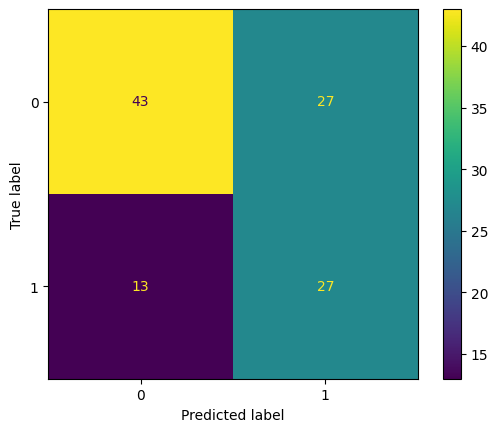

In [12]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(data_d2v, y, test_size=0.3)
X_train_tfid, X_test_tfid, y_train_tfid, y_test_tfid = train_test_split(data_d2v, y, test_size=0.3)

model = LogisticRegression(class_weight="balanced").fit(X_train_count, y_train_count)
pred = model.predict(X_test_count)

cm = confusion_matrix(pred, y_test_count)
pl = ConfusionMatrixDisplay(cm)
pl.plot()

In [13]:
print('F1 score '+str(f1_score(y_test_count, pred)))
print('recall '+str(recall_score(y_test_count, pred)))
print('precisao '+str(precision_score(y_test_count, pred)))
print('acuracia '+str(accuracy_score(y_test_count, pred)))

F1 score 0.574468085106383
recall 0.5
precisao 0.675
acuracia 0.6363636363636364


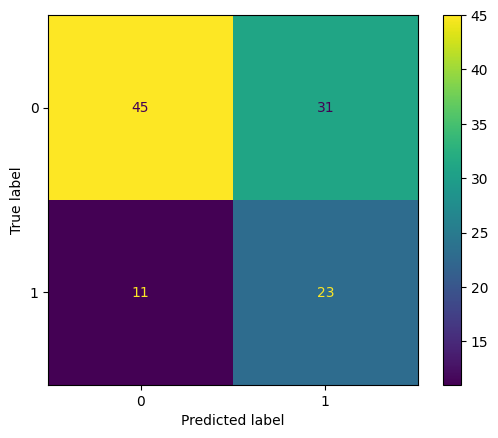

In [14]:
model = GaussianNB().fit(X_train_count, y_train_count)
pred = model.predict(X_test_count)

cm = confusion_matrix(pred, y_test_count)
pl = ConfusionMatrixDisplay(cm)
pl.plot()

In [15]:
print('F1 score '+str(f1_score(y_test_count, pred)))
print('recall '+str(recall_score(y_test_count, pred)))
print('precisao '+str(precision_score(y_test_count, pred)))
print('acuracia '+str(accuracy_score(y_test_count, pred)))

F1 score 0.5227272727272728
recall 0.42592592592592593
precisao 0.6764705882352942
acuracia 0.6181818181818182


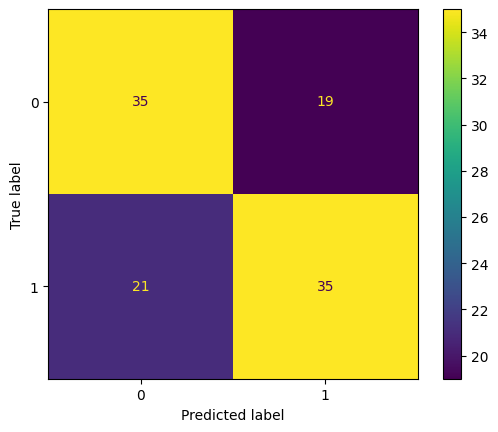

In [16]:
model = svm.SVC(class_weight="balanced").fit(X_train_count, y_train_count)
pred = model.predict(X_test_count)

cm = confusion_matrix(pred, y_test_count)
pl = ConfusionMatrixDisplay(cm)
pl.plot()

In [17]:
print('F1 score '+str(f1_score(y_test_count, pred)))
print('recall '+str(recall_score(y_test_count, pred)))
print('precisao '+str(precision_score(y_test_count, pred)))
print('acuracia '+str(accuracy_score(y_test_count, pred)))

F1 score 0.6363636363636364
recall 0.6481481481481481
precisao 0.625
acuracia 0.6363636363636364


3. Usando sua base de textos:<br>
a) Treine uma rede LSTM para gerar texto, que receba uma ou mais palavras de uma frase como entrada. O treinamento deve ser realizado considerando um conjunto supervisionado que gera a próxima palavra de uma sequência de tamanho 4, usando subsequências de sua base.

In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

def get_sequence_of_tokens(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

inp_sequences, total_words = get_sequence_of_tokens(df["text"][:500])
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    model.add(Embedding(total_words, 10, input_length=input_len))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

model.fit(predictors, label, epochs=10)

C:\Users\pedro\AppData\Local\Temp\ipykernel_19084\254402785.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  inp_sequences, total_words = get_sequence_of_tokens(df["text"][:500])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 507, 10)           58150     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5815)              587315    
                                                                 
Total params: 689,865
Trainable params: 689,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
583/583 [==============================] - 99s 167ms/step - loss: 8.2284
Epoch 2/10
583/583 [==============================] - 99s 170ms/step - loss: 7.8405
Epoch 3/10
583

In [19]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=1)
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

print(generate_text('what do you', 4, model, max_sequence_len))

What Do You I Think I M


b) Após o treinamento, exiba pelo menos 5 exemplos de textos dados de entrada, e do texto gerado em seguida pela rede treinada. Para cada exemplo, gere pelo menos 10 palavras consecutivamente.

In [20]:
print(generate_text('what do you', 10, model, max_sequence_len))
print(generate_text('who is', 10, model, max_sequence_len))
print(generate_text('what do you think', 10, model, max_sequence_len))
print(generate_text('the tech industry is', 10, model, max_sequence_len))
print(generate_text('coding is', 10, model, max_sequence_len))

What Do You I Think I M I M I M I M
Who Is I Think I Think I Think I M I M
What Do You Think I Think I M I M I M I M
The Tech Industry Is I Think I Think I Think I M I M
Coding Is I Think I Think I Think I M I M


4. Usando sua base de textos e a biblioteca spaCy, realize as seguintes tarefas:<br>
a) Extraia as etiquetas gramaticais (POS) de cada token do seu textos.<br>
b) Calcule e plote um gráfico com as frequências de cada tipo gramatical.

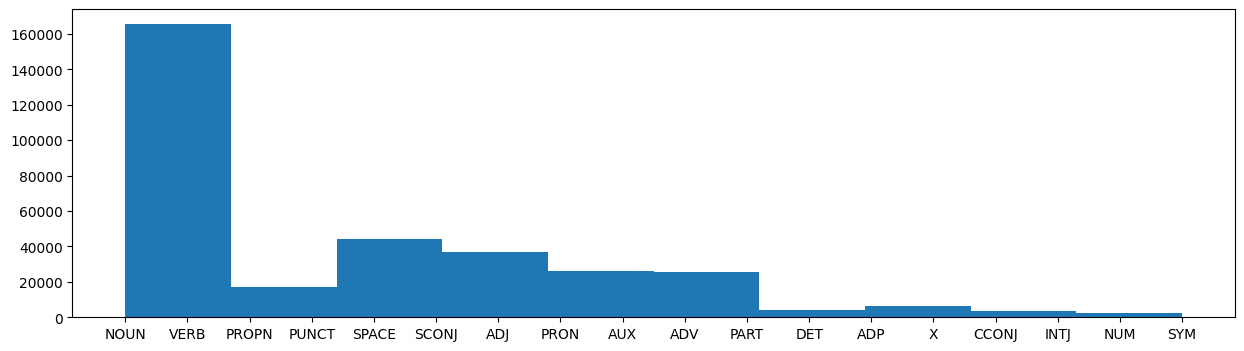

In [21]:
nlp = spacy.load("en_core_web_sm")
pos_count = []

for doc in df["text"]:
    for token in nlp(doc):
        pos_count.append(token.pos_)

plt.figure(figsize=(15,4))
plt.hist(pos_count)
plt.show()

c) Extraia entidades do tipo pessoa e lugar dos seus textos.

In [22]:
entities = []
for doc in df["text"]:
    for entity in nlp(doc).ents:
        if entity.label_ in ['PERSON', 'GPE']:
            entities.append((entity.text, entity.label_))
print(entities[:10])


[('minutuae', 'PERSON'), ('k roslyn', 'PERSON'), ('msbuild', 'PERSON'), ('asana ifttt', 'PERSON'), ('china', 'GPE'), ('north korea', 'GPE'), ('philadelphia', 'GPE'), ('mozilla jim blandy', 'PERSON'), ('malibu', 'GPE'), ('beverly hills', 'GPE')]


d) Identifique e liste as pessoas mais frequentes nos seus textos. Você só deve contar cada entidade 1 vez por documento.

In [23]:
person_freq = {}
for doc in df["text"]:
    persons = {}
    for entity in nlp(doc).ents:
        if entity.label_ == 'PERSON':
            persons[entity.text] = 1
            
    for key, value in persons.items():
        if key in person_freq:
            person_freq[key] += 1
        else:
            person_freq[key] = 1

for x in sorted(person_freq, key=person_freq.get, reverse=True)[:10]:
    print(x, person_freq[x])


https 28
kernel 22
java 14
don 13
max 10
bush 9
kinda 8
npm 8
gpu 7
enmwikipediaorg wiki 6
